## Predicción de juegos
#### Elaborado por: Dalia Yvette Domínguez Jiménez

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import CategoricalNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from random import choices

Leemos los datos de entrenamiento

In [2]:
df_ent = pd.read_csv('partidas_entrenamiento.csv')
df_ent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   id_blancas  319 non-null    int64
 1   id_negras   319 non-null    int64
 2   ganador     319 non-null    int64
dtypes: int64(3)
memory usage: 7.6 KB


Hay un total de 142 jugadores 

In [3]:
df_ent.max()

id_blancas    142
id_negras     141
ganador         1
dtype: int64

Numero de diferentes jugadores que jugaron con blancas y negras respectivamente:

In [4]:
print( 'A:',len(pd.unique(df_ent['id_blancas'])), '  B:',len(pd.unique(df_ent['id_negras'])))

A: 123   B: 114


Leemos los datos de validación

In [5]:
df_val = pd.read_csv('partidas_prueba.csv')
df_val.head()

,id_blancas,id_negras,ganador
0,35,43,1
1,45,9,0
2,55,106,0
3,35,43,1
4,35,43,1


In [6]:
df_val.max()

id_blancas    132
id_negras     136
ganador         1
dtype: int64

## Parte A

## A.1 Clasificador bayesiano ingenuo

Utilizamos el clasificador bayesiano. El cual tiene de entradas variables categóticas y de salida una variable binaria. 

In [7]:
X_ent = df_ent[df_ent.columns[:-1]].to_numpy()
y_ent = df_ent[df_ent.columns[-1]].to_numpy()

X_val = df_val[df_val.columns[:-1]].to_numpy()
y_val = df_val[df_val.columns[-1]].to_numpy()


Entrenamos el modelo

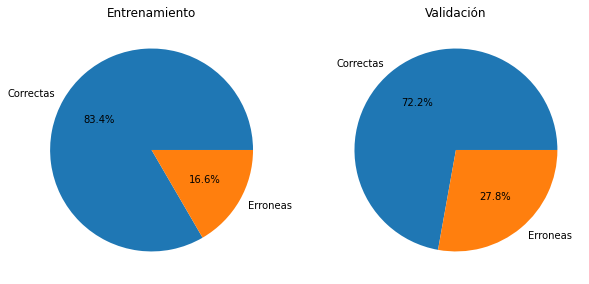

In [8]:
clf = CategoricalNB(min_categories=[142,142],alpha=2)
clf.fit(X_ent, y_ent)
y_hat_ent = clf.predict(X_ent)
corr_ent=clf.score(X_ent, y_ent)
corr_val=clf.score(X_val, y_val)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,7))
ax1.set_title('Entrenamiento')
ax1.pie([corr_ent,1-corr_ent],labels=['Correctas','Erroneas'], autopct='%1.1f%%')
ax2.set_title('Validación')
ax2.pie([corr_val,1-corr_val],labels=['Correctas','Erroneas'], autopct='%1.1f%%')
plt.show()

## A.2 Generación de datos sintéticos

Generamos 150 vectores con dos atributos aleatorios, de acuerdo a su probabilidad.

In [9]:
N=200
jugadores = np.zeros([N,2])

Para los jugadores con blancas

In [10]:
count,population=np.histogram(X_ent[:,0],bins=142,range=(1,143))
popu_prob = count/count.sum()
jugadores[:,0]=choices(population[:-1], weights=popu_prob,k=N)

Para los jugadores con negras

In [11]:
count,population=np.histogram(X_ent[:,1],bins=142,range=(1,143))
popu_prob = count/count.sum()
jugadores[:,1]=choices(population[:-1], weights=popu_prob,k=N)

Predecimos quien gana cada partida

In [12]:
ganadores = clf.predict(jugadores)
ganadores

array([1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1], dtype=int64)

Agregamos los datos generados al conjunto de entrenamiento

In [13]:
X_ent=np.concatenate((X_ent,jugadores),axis=0)
y_ent=np.concatenate((y_ent,ganadores))

Verificamos si se agregaron adecuadamente los datos generados

In [14]:
print(X_ent.shape,y_ent.shape)

(519, 2) (519,)


### Codificación de las entradas

Considerando que hay 136 diferentes jugadores que pueden jugar blancas o negras. Necesitamos 246 localidades para en las primeras 136 entradas guardar con un 1 la entrada ID-1 para indicar el jugador que juega con blanas y con las últimas 136 entras guardar con un 1 la entrada 136+ID-1 el jugador que juega con negras.

In [15]:
def codificar(data,N=136):
    data_cod = np.zeros((data.shape[0],2*N))
    for i,v in enumerate(data):
        data_cod [i,int(v[0])-1]=1
        data_cod [i,122+int(v[1])]=1
    return data_cod

In [16]:
data=codificar(X_ent,N=136)
data.shape

(519, 272)

## Parte B
### B.1 Regresión logística

#### Estandarización de los datos

Vamos a estandarizar los datos que utilizaremos, les restamos la media y hacemos que tengan una desviación estándar unitaria:

$$
\frac{x_i-\mu_i}{\sigma_i}
$$

In [17]:
def estandarizar(X):
    std = X.std(axis=0)
    std[std==0] = np.nextafter(0,1)
    return (X - X.mean(axis=0))/std

#### Función sigmoide

Definimos la función sigmoide:
$$
\sigma(a) = \frac{1}{1+e^{-a}}
$$

Observamos que para valores que tienden a $-\infty$ su probabilidad tiende a $0$, cuando los valores tienden a $\infty$ las probabilidades tienden a $1$. Y cuando tenemos valores iguales a cero, la probabilidad es de $0.5$.

In [18]:
def sigmoid(a):
    return 1.0/(1+np.e**(-a))

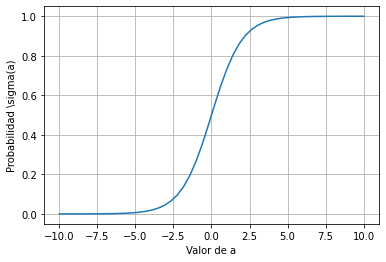

In [19]:
z =  np.linspace(-10,10)
plt.plot(z,sigmoid(z))
plt.xlabel('Valor de a')
plt.ylabel('Probabilidad \sigma(a)')
plt.grid()
plt.show()

En este caso queremos ajustar a los valores a, las entradas de atributos del conjuto de entrenamiento:

$$
a_n = \omega^T \phi(X_n) = [\omega_0 \quad \omega_1 \quad ... \omega_{m-1}] \begin{bmatrix}
1 \\
x_1 \\
. \\
. \\
. \\
x_n \\
\end{bmatrix}
$$

en donde $\omega$ son los parámetros y $X_n$ son las entradas. $\phi_n=\phi(X_n)$ es un polinomio de grado 1.

Para la regresión logística tendremos que 

$$
\sigma_n(a_n) = \frac{1}{1+e^{-a_n}}
$$

#### Función de costo: Cross-Entropy Error Function

Considerando la función de verosimilitud, para calcular los parámetros más óptimos:

$$
L(\omega) = \prod_{n=1}^N \sigma_n(w)^{y_n} (1-\sigma_n(w))^{1-y_n}
$$

Considerando 

$$
\sigma_n(w)=\frac{1}{1+e^{-w^T\phi(x_n)}}
$$

Ahora, calculamos el logaritmo negativo de $L$:

$$
E(\omega) = - \ln{L(\omega)} = - \sum_{n=1}^N  [y_n \ln{\sigma_n(w)} + (1-y_n)\ln{(1-\sigma_n(w))} ]
$$

In [20]:
def loss(X,y,weights):
    phi=np.c_[np.ones((X.shape[0],1)),X]
    a=phi@weights
    yhat=sigmoid(a)
    return -np.mean( (y*np.log(yhat)) + (1-y)*(np.log(1-yhat)) )

Se observa que la función de pérdida se minimiza cuando se predice correctamente y se maximiza cuando la predicción es incorrecta.

#### Gradiante de la función de error


Para encontrar los parámetros óptimos utilizamos el descenso por gradiante:

$$
\bigtriangledown E = \sum_{n=1}^N \big( \sigma_n(w) - y_n \big) \phi_n = \Phi^T(\mathbf{\sigma}(\omega)-Y)
$$




In [21]:
def gradiante(X,phi,weights,y): 
    a=phi@weights
    yhat=sigmoid(a)
    y = y.reshape(y.shape[0],1)
    return phi.T@(yhat-y)

#### Actualización de parámetros

Para actualizar los parámetros utilizamos:

$$
\omega^{new} = \omega^{old} - \alpha \bigtriangledown E 
$$

En este caso usaremos $400$ iteraciones y $\alpha=0.001$

In [22]:
def inicializar(X):
    n_att = X.shape[0]
    phi=np.c_[np.ones((X.shape[0],1)),X]
    weights = np.zeros([phi.shape[1],1])
    return phi, weights
    
def fit(X,y,alpha=0.001,n_iter=400):
    X = estandarizar(X)
    phi, weights = inicializar(X)
    for i in range(n_iter):
        weights = weights - alpha*gradiante(X,phi,weights,y)
        coef_ = weights
        yield coef_

Observemos como se actualizan los parámetros con los datos de entrenamiento:

In [23]:
weights=[w for w in fit(data,y_ent,alpha=0.03,n_iter=900)]
weights=np.array(weights)
weights.shape

(900, 273, 1)

In [24]:
weights=[w for w in fit(data,y_ent,alpha=0.01,n_iter=1000)]
weights=np.array(weights)
weights.shape

(1000, 273, 1)

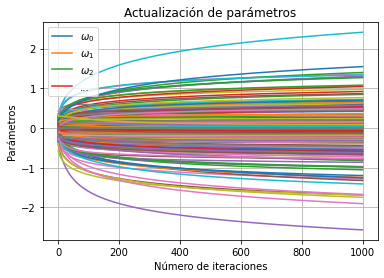

In [25]:
for i in range(238):
    plt.plot(weights[:,i,0])
plt.xlabel('Número de iteraciones')
plt.ylabel('Parámetros')
plt.legend(['$\omega_0$','$\omega_1$','$\omega_2$','...'])
plt.title('Actualización de parámetros')
plt.grid()
plt.show()

#### Predicciones

Hacemos las siguientes predicciones, considerando un umbral $u$:

$$
\hat{y}_n = 
\left\{\begin{matrix}
 &  &  \\
1, &  \sigma_n(w)> u&  \\
 &  &  \\
 &  &  \\
0, &  \sigma_n(w)\leq u&  \\
 &  &  \\
\end{matrix}\right.
$$

In [26]:
def predict(X,y,umbral=0.5):
    phi=np.c_[np.ones((X.shape[0],1)),X]
    weights=[w for w in fit(X_ent,y_ent,alpha=0.001,n_iter=100)]
    weights=np.array(weights)
    a=phi@weights[-1,:,0]
    return [1 if sigma>umbral else 0 for sigma in sigmoid(a)]

Graficamos el error para cada iteración

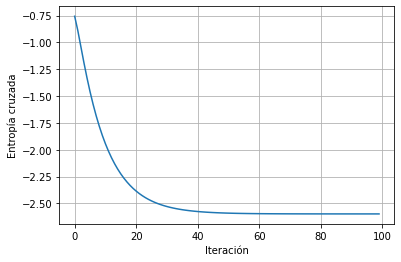

In [27]:
ypred=predict(X_ent,y_ent)
losses=[-loss(X_ent,y_ent,w) for w in fit(X_ent,y_ent,alpha=0.001,n_iter=100)]
plt.plot(losses)
plt.xlabel(u'Iteración')
plt.ylabel(u'Entropía cruzada')
plt.grid()
plt.show()

### B.2 Clase RegresionLogistica

Juntamos las funciones anteriores para formar una clase. Hacemos algunas correcciones para poder trabajar con la clase.

In [28]:
class RegresionLogistica():
    
    def estandarizar(self,X):
        std = X.std(axis=0)
        std[std==0] = np.nextafter(0,1)
        return (X - X.mean(axis=0))/std
    
    def sigmoid(self,a):
        return 1.0/(1+np.e**(-a))
    
    def inicializar(self,X):
        self.n__att = X.shape[0]
        phi=np.c_[np.ones((X.shape[0],1)),X]
        weights = np.zeros([phi.shape[1],1])
        return phi, weights
        
    def gradiante(self,phi,weights,y): 
        a=phi@weights
        yhat=self.sigmoid(a)
        y = y.reshape(y.shape[0],1)
        return phi.T@(yhat-y)
    
    def fit(self,X,y,alpha=0.001,n_iter=400):
        X = self.estandarizar(X)
        phi, weights = self.inicializar(X)
        for i in range(n_iter):
            weights = weights - alpha*self.gradiante(phi,weights,y)
        self.coef_ = weights
    
    def predict(self,X,umbral=0.5):
        phi=np.c_[np.ones((X.shape[0],1)),X]
        return [1 if sigma>umbral else 0 for sigma in self.sigmoid(phi@self.coef_)]
    
    def loss(self, X,y,weights):
        yhat=sigmoid(self.phi@self.coef_)
        return -np.mean( (y*np.log(yhat)) + (1-y)*(np.log(1-yhat)) )

Para entrenar el modelo:

In [29]:
rl=RegresionLogistica()
rl.fit(data,y_ent)
rl.coef_.shape

(273, 1)

### B.3 Curvas ROC

Para calcular las curvas ROC utilizamos la matriz de confusión:

In [30]:
def ROC(m,X,y,umbrales):
    rates=np.zeros((umbrales.shape[0],3))
    for i,umbral in enumerate(umbrales):
        yhat = m.predict(X,umbral)
        cm = confusion_matrix(y,yhat)
        rates[i,0] = cm[0,1]/(cm[0,0]+cm[0,1]) #Tasa falsos positivos
        rates[i,1] = cm[1,1]/(cm[1,0]+cm[1,1]) #Tasa verdaderos positivos
        if cm[0,1]+cm[1,1] == 0:
            rates[i,2] = 1
        else:
            rates[i,2] = cm[1,1]/(cm[0,1]+cm[1,1]) # Precision
    return rates

Codificamos las entradas de validación

In [31]:
data_val=codificar(X_val)

Calculamos las curvas ROC con diferentes umbrales de probabilidad, tanto en el conjunto de entrenamiento como de validación.

In [32]:
umbrales = np.linspace(0,1,100)
for umbral in umbrales:
    rates_ent=ROC(rl,data,y_ent,umbrales)
    rates_val=ROC(rl,data_val,y_val,umbrales)

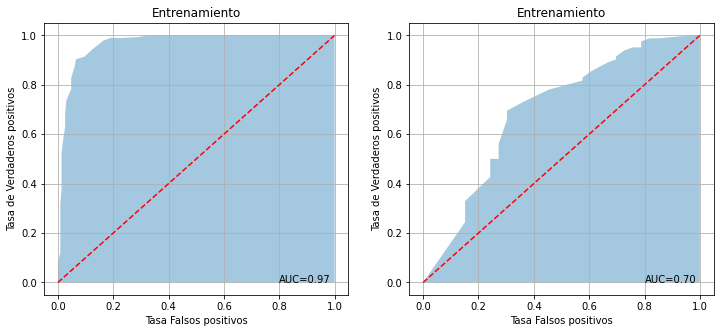

In [33]:
x=np.linspace(0,1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.fill_between(rates_ent[:,0],rates_ent[:,1], alpha=0.4)
plt.text(0.8,0,'AUC={auc_ent:.2f}'.format(auc_ent=metrics.auc(rates_ent[:,0],rates_ent[:,1])))
plt.plot(x,x,'r--')
plt.xlabel('Tasa Falsos positivos')
plt.ylabel('Tasa de Verdaderos positivos')
plt.title('Entrenamiento')
plt.grid()

plt.subplot(1,2,2)
plt.fill_between(rates_val[:,0],rates_val[:,1], alpha=0.4)
plt.text(0.8,0,'AUC={auc_ent:.2f}'.format(auc_ent=metrics.auc(rates_val[:,0],rates_val[:,1])))
plt.plot(x,x,'r--')
plt.xlabel('Tasa Falsos positivos')
plt.ylabel('Tasa de Verdaderos positivos')
plt.title('Entrenamiento')
plt.grid()

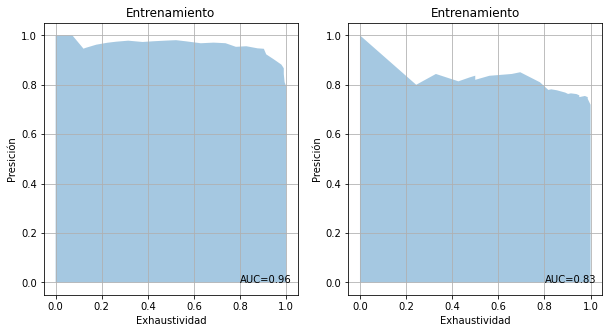

In [34]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.fill_between(rates_ent[:,1],rates_ent[:,2], alpha=0.4)
plt.text(0.8,0,'AUC={auc_ent:.2f}'.format(auc_ent=metrics.auc(rates_ent[:,1],rates_ent[:,2])))
plt.xlabel('Exhaustividad')
plt.ylabel('Presición')
plt.title('Entrenamiento')
plt.grid()

plt.subplot(1,2,2)
plt.fill_between(rates_val[:,1],rates_val[:,2], alpha=0.4)
plt.text(0.8,0,'AUC={auc_ent:.2f}'.format(auc_ent=metrics.auc(rates_val[:,1],rates_val[:,2])))
plt.xlabel('Exhaustividad')
plt.ylabel('Presición')
plt.title('Entrenamiento')
plt.grid()

## C. Comparación

Compara el clasificador bayesiano ingenuo y regresión logística en este problema. 
- ¿Qué ventajas y desventajas tienen los modelos entrenados? 
    * Por un lado, el clasificador bayesiano ingenuo tiene la ventaja que no fue necesario codificar las entradas, pues se puede utilizar un clasificador con variables de entrada categóricas, una desventaja es que a comparación de la regresión logistica, modela la probabilidad conjunta de las entradas y las salidas, no modela directamente la probabilidad condicional, por lo que se puede ver un menor desempeño en el conjunto de entrenamiento.
    * Por otro lado, la ventaja de la regresión logísitca es que se trata de un problema de optimización, tiene un buen resultado en el conjunto de entrenamiento, sin embargo parece que el modelo se sobreajusta pues el rendimiento en el conjunto de validación se reduce bastante.
    
- ¿Qué pasaría si se entrena el clasificador bayesiano ingenuo con los vectores recodificados o si se entrena un modelo de regresión logística usando los vectores de entrada originales? 

    * Si se utilizaran los vectores recodificados para entrenar el clasificador bayesianos se tendría que utilizar un clasificador con distribuciones de bernoulli para las entradas binarias, esto resultaría en un mayor número de atributos para cada vector y, debido a que el clasificador bayesiano aproxima la probabilidad condicional a través de multiplicaciones, el resultado puede ser muy pequeño y menos preciso.
    
    * Si se entrena el modelo de regresión logistica con los vectores sin codificar (se realizó este ejercicio más abajo en la última figura), se obtiene un bajo desempeño, pues los datos se distribuyen de forma categórica. Además, la regresión intenta encontrar el plano o hiperplano que separa en el espacio a ambas clases. Sin embargo, como se puede ver en la figura siguiente, en un espacio de 2 dimensiones las muestras se sobrelapan demasiado que al calcular una función discrminante en este espacio, podría haber muchas predicciones erroneas.
    

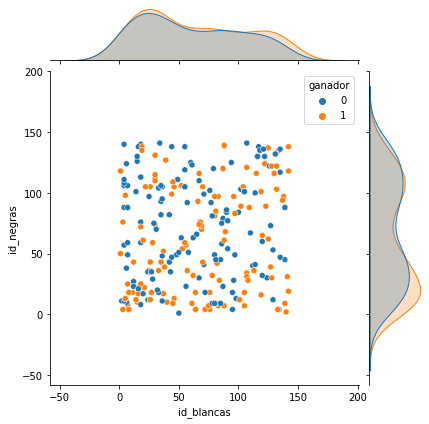

In [38]:
sns.jointplot(data=df_ent, x='id_blancas', y='id_negras', hue="ganador")

- Aqui se puede observar que la transformación lineal de los parámetros sin codificar a la variable $a$, no separa ambas clases, pues al calcular $\sigma(a)$ (la probabilidad de cada vector de entrada) ambas clases se sobrelapan.

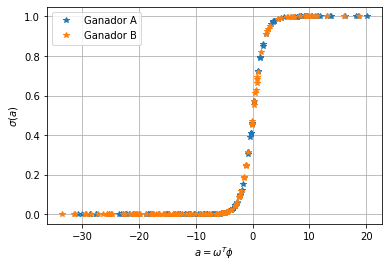

In [39]:
X_ent = df_ent[df_ent.columns[:-1]].to_numpy()
y_ent = df_ent[df_ent.columns[-1]].to_numpy()
rl=RegresionLogistica()
rl.fit(X_ent,y_ent)
[X,w]=rl.inicializar(X_ent[y_ent==1,:])
a=X@rl.coef_

plt.plot(a,sigmoid(a),'*')

[X,w]=rl.inicializar(X_ent[y_ent==0,:])
a=X@rl.coef_

plt.plot(a,sigmoid(a),'*')
plt.xlabel('$a=\omega^T\phi$')
plt.ylabel('$\sigma(a)$')
plt.legend(('Ganador A', 'Ganador B'))
plt.grid()
plt.show()

- ¿Consideras que las presuposiciones de cada clasificador son apropiadas para los datos del problema? 
    * En cuanto al clasificador bayesiano ingenuo, las variables de entrada son categóricas y es apropiado que supones que hay independencia condicional.
    * Para la regeresión logistica se cambio la codificación de las entradas para que cumpliera esta presuposición.
- ¿Para este tipo de problemas cuál de los dos recomendarías y por qué?
    * Al considerar el valor AUC para regresión logistica la clasificiación es excelente para el conjunto de entrenamiento, pero para el conjunto de validación la clasificación es regular. Por lo que recomendaría el clasificador bayesiano, por que se tiene mayor generalización además que no se necesita recodificar las entradas.

## D. Derivar la regla de optimización

$$
E(\theta) = \frac{1}{2} \sum_i (\hat y ^{(i))}-y^{(i)})^2 = \frac{1}{2} \sum_i ( \sigma(a) ^{(i)}-y^{(i)})^2
$$

considerando $\sigma(a) = sigm(\theta^TX)$. Utilizando regla de la cadena:

$$
\bigtriangledown E(\theta) = \frac{1}{2}\sum_i \frac{\partial (\sigma^{(i)}-y^{(i)})^2}{\partial a} \bigtriangledown a(\theta)
$$

$$
= \frac{1}{2}\sum_i 2 (\sigma^{(i)}-y^{(i)}) \sigma'^{(i)} \bigtriangledown \sum_m \theta_mx_m 
$$
Pues $\sigma'= \sigma (1-\sigma)$
$$
= \sum_i  (\sigma^{(i)}-y^{(i)}) \sigma^{(i)} (1-\sigma^{(i)})X
$$
De esta forma la regla de actualización queda:

$$
\omega^{new} = \omega^{old} - \alpha \bigtriangledown E 
$$

$$
\omega^{new} = \omega^{old} - \alpha \sum_i  (\sigma^{(i)}-y^{(i)}) \sigma^{(i)} (1-\sigma^{(i)})X
$$